In [1]:
import numpy as np
import os
from PIL import Image, ImageDraw
from datasets import load_dataset

import ast

c:\Users\Win 11\.conda\envs\env_pt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = load_dataset('arrow', data_files=r'E:\projects\Personal\GazeTransformers\data\test\*.arrow', split='train')

In [3]:
data[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=640x480>,
 'split': 'test',
 'width': 640,
 'height': 480,
 'bboxes': '[[387.0, 108.0, 414.0, 148.0], [385.0, 232.0, 411.0, 271.0], [382.0, 286.0, 407.0, 324.0], [501.0, 371.0, 521.0, 402.0], [504.0, 344.0, 523.0, 377.0], [490.0, 361.0, 503.0, 391.0], [492.0, 335.0, 511.0, 367.0], [480.0, 352.0, 491.0, 381.0], [482.0, 327.0, 499.0, 358.0], [470.0, 344.0, 481.0, 372.0], [472.0, 320.0, 488.0, 349.0], [451.0, 264.0, 476.0, 296.0], [452.0, 241.0, 481.0, 272.0], [434.0, 254.0, 452.0, 282.0], [435.0, 232.0, 460.0, 260.0], [269.0, 318.0, 300.0, 336.0], [268.0, 299.0, 300.0, 319.0], [566.0, 405.0, 590.0, 465.0], [550.0, 391.0, 574.0, 448.0], [534.0, 379.0, 557.0, 433.0], [520.0, 367.0, 541.0, 419.0], [226.0, 328.0, 260.0, 339.0], [226.0, 319.0, 260.0, 330.0], [226.0, 311.0, 260.0, 322.0], [225.0, 300.0, 260.0, 313.0], [190.0, 331.0, 225.0, 342.0], [190.0, 323.0, 225.0, 334.0], [189.0, 314.0, 224.0, 325.0], [189.0, 303.0, 224.0, 31

In [4]:
import json

obj_class = {}
with open('E:\projects\Personal\GazeTransformers\data\objectclass.txt', 'r') as file:
    texts = file.readlines()
    for item in texts:
        text = item.split('=')
        obj_class[text[1].strip()] = text[0].strip()

def convert_str_to_list(x):
    return ast.literal_eval(x)

In [5]:
id2label = {index: obj_class[str(x)] for index, x in enumerate(convert_str_to_list(data[0]['labels']), start=0)}
label2id = {v: k for k, v in id2label.items()}
label2id

{"Kellogg's Corn Flakes": 0,
 'Honey Stars': 1,
 'Koko Krunch': 2,
 'Fita': 10,
 'Mamon': 14,
 'Buttercake': 16,
 'Wafer': 20,
 'Choco Crunchies': 28,
 'iHop': 33,
 'Butterlicious': 39,
 'Pik-nik': 43,
 'Pringles': 49,
 'Super Fruits': 55,
 'Locally Mango': 61,
 'Camomille': 69,
 'Oishi Prawn': 73,
 'Kimchi Noodles': 81,
 'Hansel': 85,
 'Danisa': 86,
 'Chocolate Chips': 90,
 'Fresh Milk': 91,
 'Bear brand': 95,
 'Chuckie': 99,
 'Head': 100}

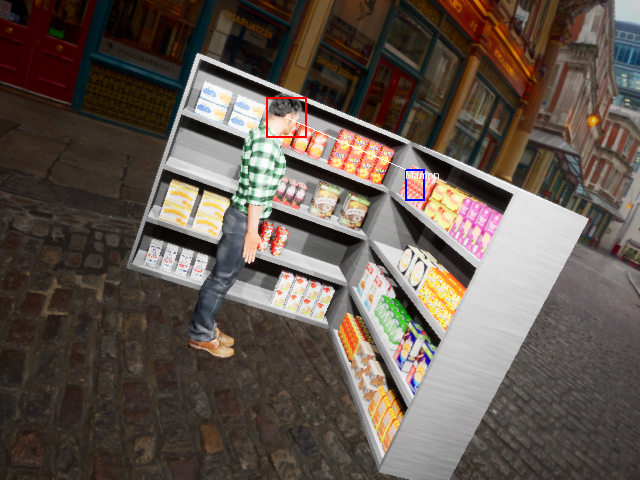

In [6]:
def load_category(example):
    ls_bbox = convert_str_to_list(example['bboxes'])
    ls_labels = convert_str_to_list(example['labels'])   
        
    draw = ImageDraw.Draw(example['image'])
    for idx, (label, box) in enumerate(zip(ls_labels, ls_bbox)):
        if idx == example['gazeIdx']:
            
            # draw categogy
            x, y, w, h = tuple(box)
            draw.rectangle((x, y, w, h), outline="blue", width=2)
            draw.text((x, y), id2label[label], fill="white")
            
            # bbox head 
            hx, hy, = tuple((example['hx'], example['hy']))
            # print("x: ", x, "\ty: ", y)
            draw.rectangle((hx-20, hy-20, hx+20, hy+20), outline="red", width=2)
            
            # draw line
            draw.line((hx, hy, x,y), width = 0) 
            
    return example['image']

load_category(data[350])
    

Processor image

In [8]:
from transformers import DetrImageProcessor
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests


ckpt = "facebook/detr-resnet-50"
image_processor = DetrImageProcessor.from_pretrained(ckpt)

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

In [10]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


In [14]:
inputs = processor(images=data[350]['image'].convert("RGB"), return_tensors="pt")

In [17]:
inputs = processor(images=data[350]['image'].convert("RGB"), return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([data[350]['image'].size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected person with confidence 1.0 at location [186.05, 90.97, 302.96, 357.48]


In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bkai-foundation-models/vietnamese-bi-encoder')

tokenizer.save_pretrained('tokenizer_bkai')

('tokenizer_bkai\\tokenizer_config.json',
 'tokenizer_bkai\\special_tokens_map.json',
 'tokenizer_bkai\\vocab.txt',
 'tokenizer_bkai\\bpe.codes',
 'tokenizer_bkai\\added_tokens.json')

'pwd' is not recognized as an internal or external command,
operable program or batch file.
